<a href="https://colab.research.google.com/github/Lcocks/DS6050-DeepLearning/blob/main/12_2_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu
PART 1: The Averaging Problem


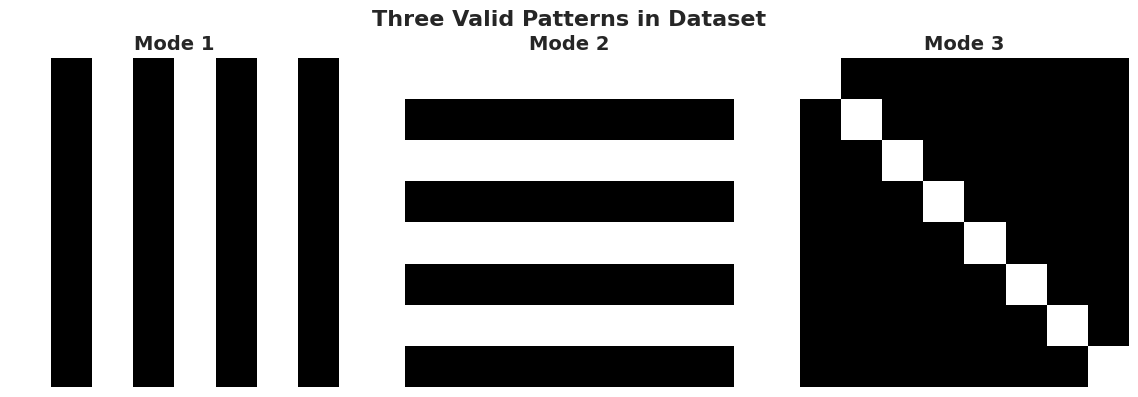


What happens if we try to predict these patterns with MSE loss?
Computing the mean pattern...


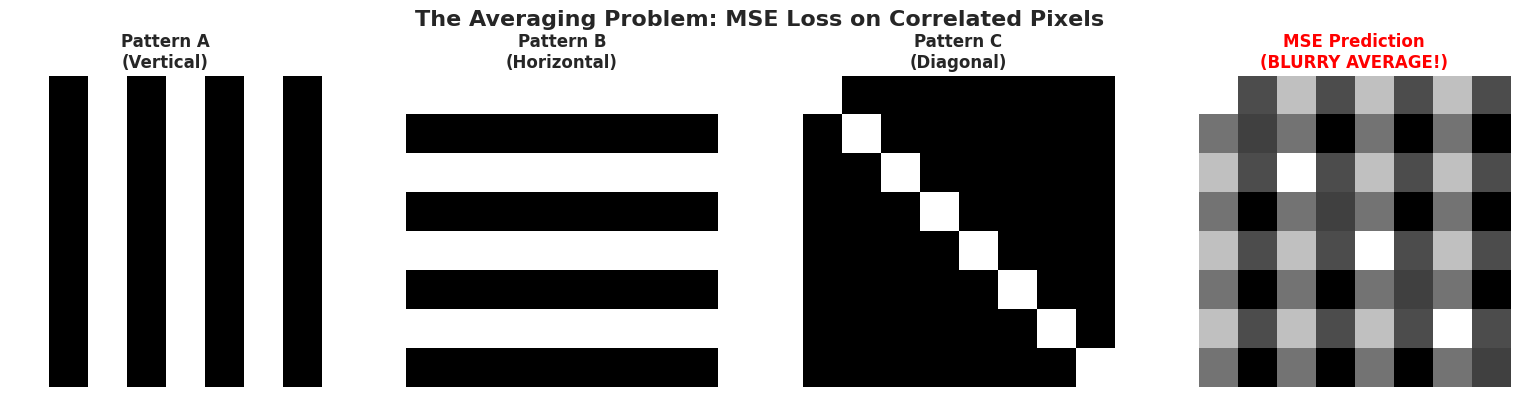


OBSERVATION: MSE loss produces a blurry average!
The model hedges its bets by outputting the mean.
This is because pixels are highly correlated.


PART 2: The Key Insight - Noise Breaks Correlations


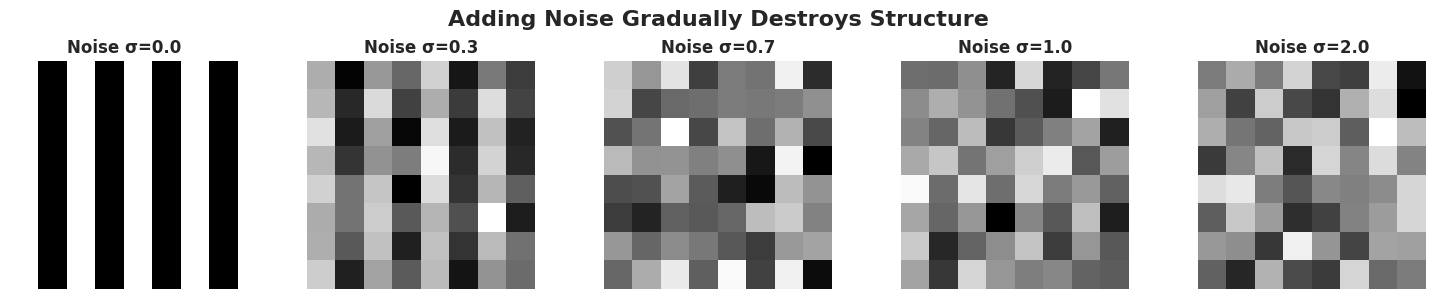


Key Insight:
- At high noise, pixel correlations are broken
- Noise is INDEPENDENT across all pixels
- We can predict independent values in parallel without averaging!


PART 3: The Forward Diffusion Process
Total timesteps T = 1000
Beta range: [0.0001, 0.9990]
Alpha_bar range: [0.0000, 0.9999]


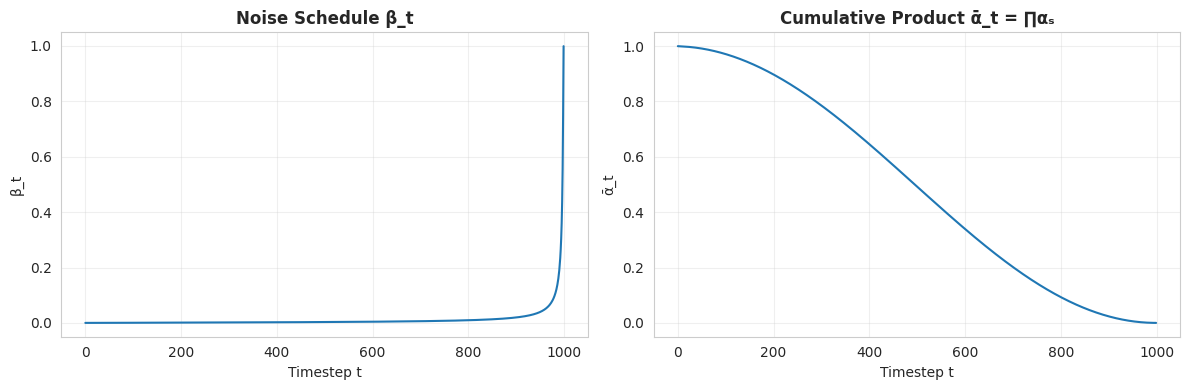


Forward process equation:
x_t = √(ᾱ_t) * x_0 + √(1 - ᾱ_t) * ε
where ε ~ N(0, I)

This closed form lets us jump to ANY timestep directly!


100%|██████████| 9.91M/9.91M [00:00<00:00, 60.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.73MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.10MB/s]



Using MNIST digit: 5


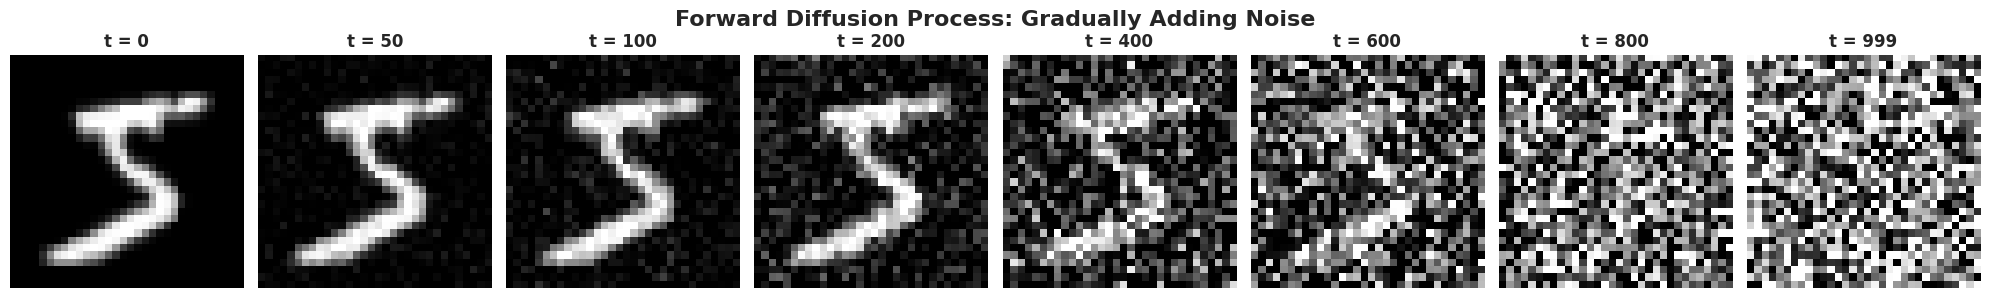


Notice: By t=999, the image is pure Gaussian noise!
The structure is completely destroyed.


PART 4: The Reverse Process - Learning to Denoise

Challenge: We need to reverse the diffusion process
- Forward: x_0 → x_T (easy, we know the formula)
- Reverse: x_T → x_0 (hard, need to learn!)

Key insight: If we can predict the noise ε that was added,
we can remove it to recover x_0!

Training objective (simple MSE):
    L = E_t,x_0,ε [ ||ε - ε_θ(x_t, t)||² ]

This is just: "predict the noise we added"


U-Net Architecture:
- Input: Noisy image x_t + timestep t
- Output: Predicted noise ε_θ(x_t, t)
- Timestep embedding: Sinusoidal (like Transformers from Lecture 8!)
- Skip connections: From U-Net (Lecture 6!)

Model parameters: 977,985


PART 5: Training the Diffusion Model

Training diffusion model (this may take a few minutes)...
Training objective: Predict the noise we added



Epoch 1/2:   0%|          | 0/468 [00:00<?, ?it/s]

Epoch 1: Average Loss = 0.1477


Epoch 2/2:   0%|          | 0/468 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bed8c361800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bed8c361800>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2: Average Loss = 0.0652


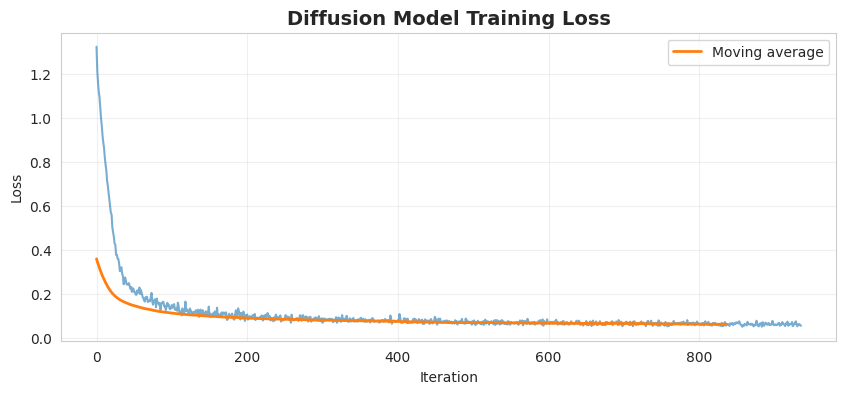


Training complete!
The model has learned to predict noise at any timestep t


PART 6: Sampling - Generating New Images

Sampling process:
1. Start with pure noise x_T ~ N(0, I)
2. For t = T, T-1, ..., 1:
   - Predict noise: ε_θ(x_t, t)
   - Remove noise to get x_{t-1}
3. Return x_0

This reverses the diffusion process!


Generating samples with DDIM (faster, deterministic)...


DDIM Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

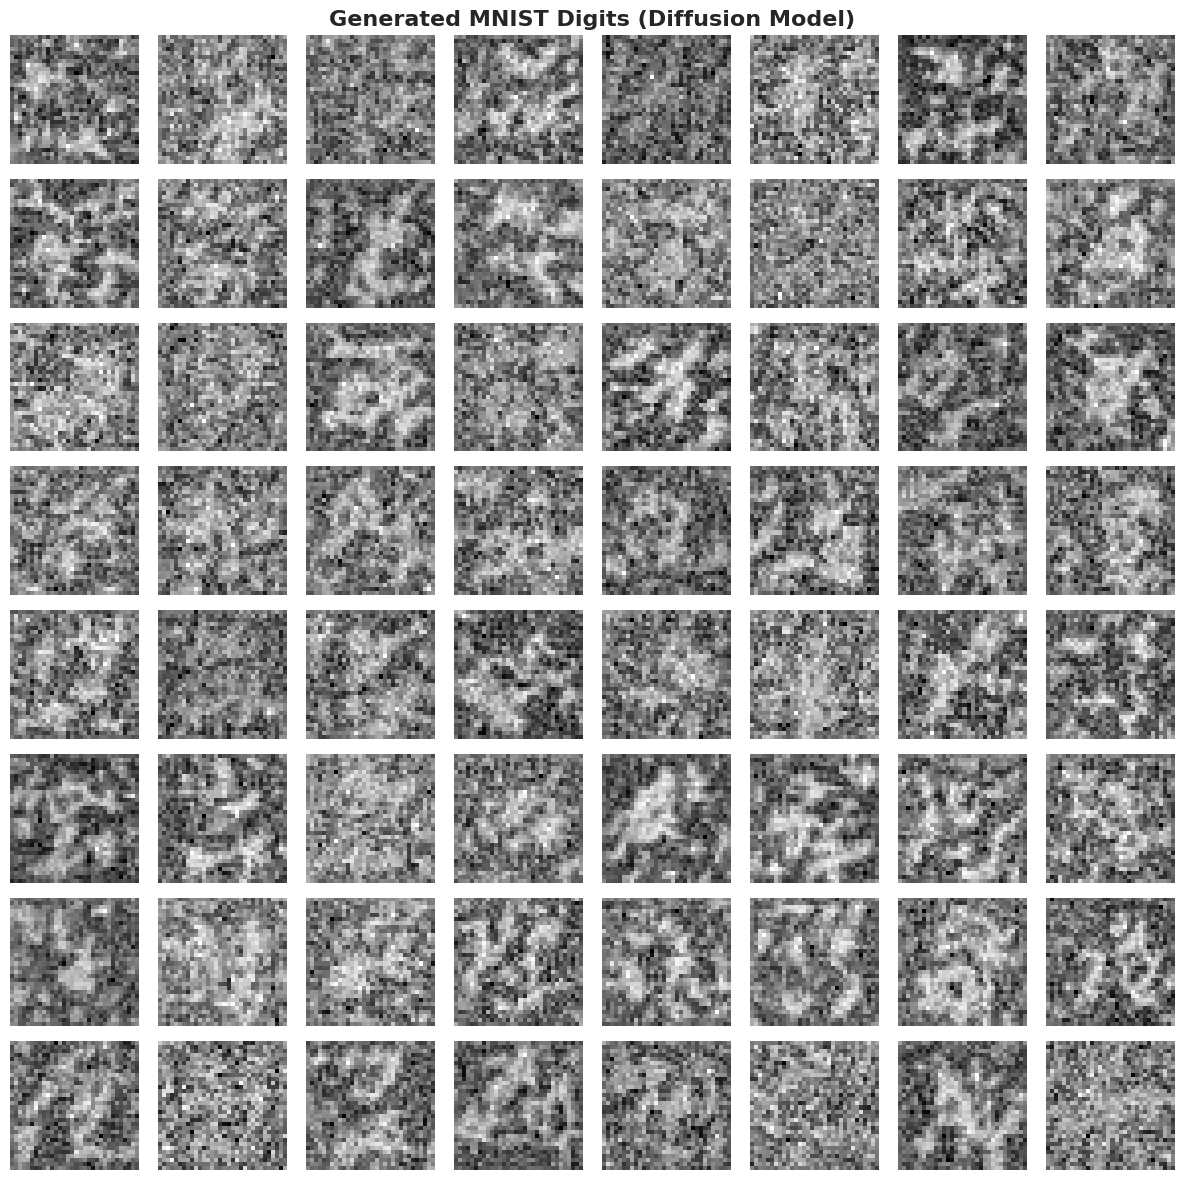


Success! We generated new images by denoising!


PART 7: Visualizing the Denoising Process
Capturing denoising process...


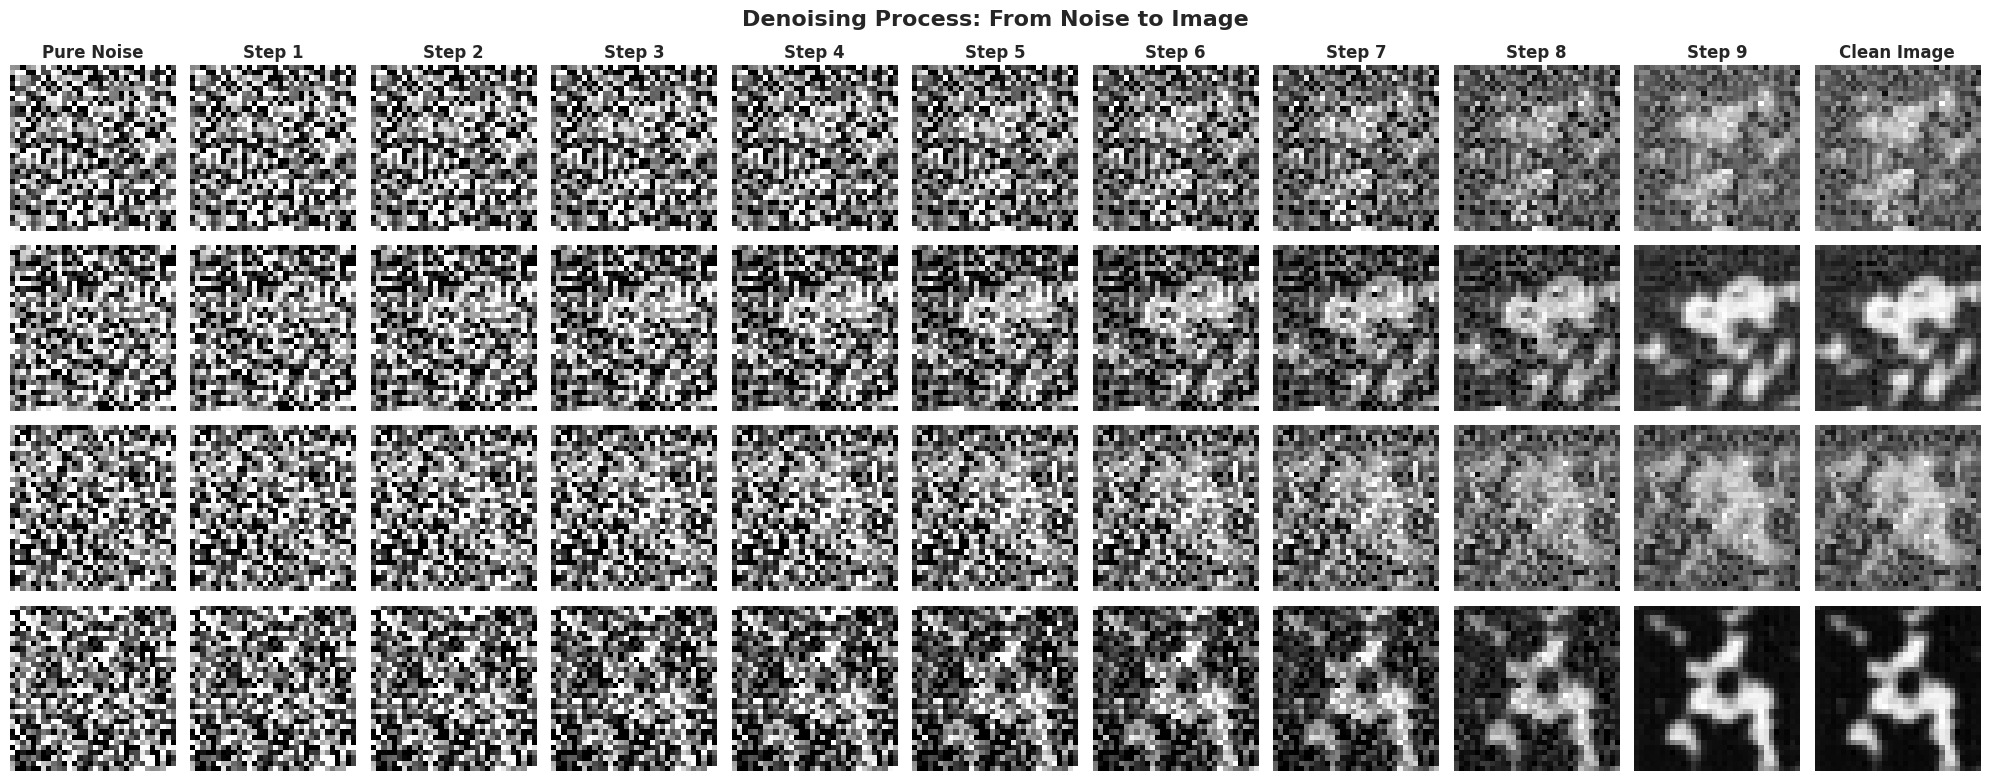


Notice how structure gradually emerges from noise!
Early steps: Global structure (shape, orientation)
Later steps: Fine details (edges, texture)


PART 8: Key Insights

╔══════════════════════════════════════════════════════════════╗
║                    KEY INSIGHTS                              ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  1. THE AVERAGING PROBLEM                                    ║
║     • Predicting correlated pixels → blur                    ║
║     • MSE loss hedges bets by averaging                      ║
║                                                              ║
║  2. NOISE BREAKS CORRELATIONS                                ║
║     • Gaussian noise is INDEPENDENT across pixels            ║
║     • Can predict all pixels in parallel!                    ║
║     • No averaging needed                                    ║
║                                                 

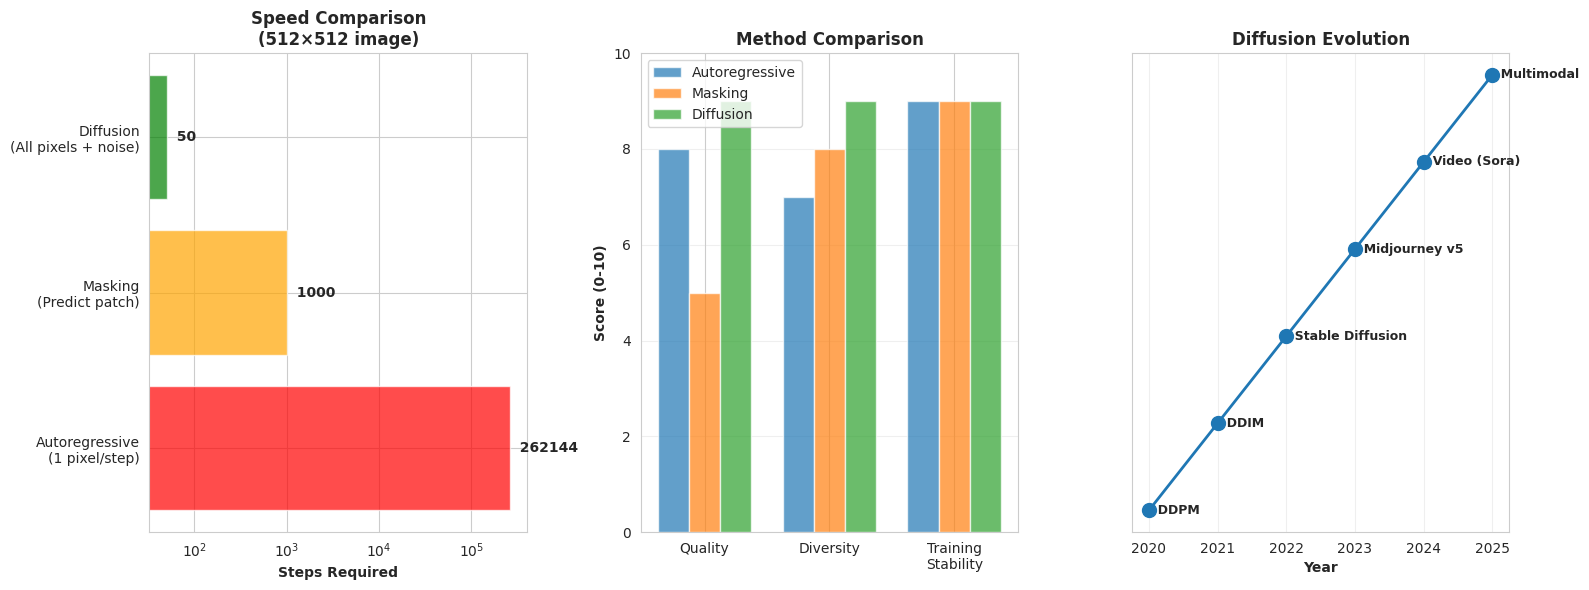


DEMONSTRATION COMPLETE!

What we've learned:
1. Why predicting correlated pixels fails (averaging)
2. How noise breaks correlations (independence)
3. The forward diffusion process (adding noise)
4. The reverse process (learning to denoise)
5. Training is simple: predict the noise!
6. Sampling: iteratively denoise from pure noise
7. Diffusion > 2000× faster than autoregressive for images

This is why diffusion models won!


In [ ]:
"""
Diffusion Models Demo
=================================

This notebook accompanies Lecture 12.2 on Diffusion Models.
We'll understand:
1. Why predicting correlated pixels fails (averaging problem)
2. How adding noise breaks correlations
3. The forward diffusion process
4. The reverse denoising process
5. Score functions and generation
6. Practical DDPM implementation
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display, Markdown
import math
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

#==============================================================================
# PART 1: The Averaging Problem - Why Direct Prediction Fails
#==============================================================================

print("=" * 70)
print("PART 1: The Averaging Problem")
print("=" * 70)

def create_multimodal_images():
    """
    Create simple 8x8 images with multiple valid completions
    This demonstrates why MSE on correlated pixels fails
    """
    # Base pattern (vertical bars)
    pattern_a = torch.zeros(8, 8)
    pattern_a[:, [0, 2, 4, 6]] = 1.0

    # Alternative pattern (horizontal bars)
    pattern_b = torch.zeros(8, 8)
    pattern_b[[0, 2, 4, 6], :] = 1.0

    # Another pattern (diagonal)
    pattern_c = torch.eye(8)

    # Create dataset with multiple patterns
    data = []
    for _ in range(100):
        choice = np.random.choice([0, 1, 2])
        if choice == 0:
            data.append(pattern_a)
        elif choice == 1:
            data.append(pattern_b)
        else:
            data.append(pattern_c)

    return torch.stack(data), [pattern_a, pattern_b, pattern_c]

# Create multimodal data
data, patterns = create_multimodal_images()

# Visualize the three modes
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for idx, (ax, pattern) in enumerate(zip(axes, patterns)):
    ax.imshow(pattern.numpy(), cmap='gray', vmin=0, vmax=1)
    ax.set_title(f'Mode {idx+1}', fontsize=14, fontweight='bold')
    ax.axis('off')
plt.suptitle('Three Valid Patterns in Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# What happens with MSE loss?
print("\nWhat happens if we try to predict these patterns with MSE loss?")
print("Computing the mean pattern...")

mean_pattern = data.mean(dim=0)

fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(patterns[0].numpy(), cmap='gray', vmin=0, vmax=1)
axes[0].set_title('Pattern A\n(Vertical)', fontweight='bold')
axes[0].axis('off')

axes[1].imshow(patterns[1].numpy(), cmap='gray', vmin=0, vmax=1)
axes[1].set_title('Pattern B\n(Horizontal)', fontweight='bold')
axes[1].axis('off')

axes[2].imshow(patterns[2].numpy(), cmap='gray', vmin=0, vmax=1)
axes[2].set_title('Pattern C\n(Diagonal)', fontweight='bold')
axes[2].axis('off')

axes[3].imshow(mean_pattern.numpy(), cmap='gray', vmin=0, vmax=1)
axes[3].set_title('MSE Prediction\n(BLURRY AVERAGE!)',
                  fontweight='bold', color='red')
axes[3].axis('off')

plt.suptitle('The Averaging Problem: MSE Loss on Correlated Pixels',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("OBSERVATION: MSE loss produces a blurry average!")
print("The model hedges its bets by outputting the mean.")
print("This is because pixels are highly correlated.")
print("=" * 70)

#==============================================================================
# PART 2: The Key Insight - Add Noise to Break Correlations
#==============================================================================

print("\n\n" + "=" * 70)
print("PART 2: The Key Insight - Noise Breaks Correlations")
print("=" * 70)

def add_noise_to_pattern(pattern, noise_level):
    """Add Gaussian noise to pattern"""
    noise = torch.randn_like(pattern) * noise_level
    return pattern + noise

# Show how noise breaks structure
pattern = patterns[0]  # Vertical bars
noise_levels = [0.0, 0.3, 0.7, 1.0, 2.0]

fig, axes = plt.subplots(1, len(noise_levels), figsize=(15, 3))
for idx, noise_level in enumerate(noise_levels):
    noisy = add_noise_to_pattern(pattern, noise_level)
    axes[idx].imshow(noisy.numpy(), cmap='gray')
    axes[idx].set_title(f'Noise σ={noise_level}', fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Adding Noise Gradually Destroys Structure',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("- At high noise, pixel correlations are broken")
print("- Noise is INDEPENDENT across all pixels")
print("- We can predict independent values in parallel without averaging!")
print("=" * 70)

#==============================================================================
# PART 3: Forward Diffusion Process - Step by Step
#==============================================================================

print("\n\n" + "=" * 70)
print("PART 3: The Forward Diffusion Process")
print("=" * 70)

def get_beta_schedule(T, schedule_type='linear'):
    """
    Create noise schedule
    β_t controls how much noise to add at each step
    """
    if schedule_type == 'linear':
        return torch.linspace(1e-4, 0.02, T)
    elif schedule_type == 'cosine':
        steps = T + 1
        x = torch.linspace(0, T, steps)
        alphas_cumprod = torch.cos(((x / T) + 0.008) / 1.008 * math.pi * 0.5) ** 2
        alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
        betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
        return torch.clip(betas, 0.0001, 0.999)

# Set up diffusion parameters
T = 1000  # Total timesteps
betas = get_beta_schedule(T, 'cosine')
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

print(f"Total timesteps T = {T}")
print(f"Beta range: [{betas.min():.4f}, {betas.max():.4f}]")
print(f"Alpha_bar range: [{alphas_cumprod.min():.4f}, {alphas_cumprod.max():.4f}]")

# Visualize the schedule
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(betas.numpy())
ax1.set_xlabel('Timestep t')
ax1.set_ylabel('β_t')
ax1.set_title('Noise Schedule β_t', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(alphas_cumprod.numpy())
ax2.set_xlabel('Timestep t')
ax2.set_ylabel('ᾱ_t')
ax2.set_title('Cumulative Product ᾱ_t = ∏αₛ', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nForward process equation:")
print("x_t = √(ᾱ_t) * x_0 + √(1 - ᾱ_t) * ε")
print("where ε ~ N(0, I)")
print("\nThis closed form lets us jump to ANY timestep directly!")

# Demonstrate forward process on a real image
# Load a single MNIST digit
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # to [-1, 1]
])

mnist_data = datasets.MNIST(root='./data', train=True, download=True,
                            transform=transform)
sample_img, label = mnist_data[0]  # Get first image
print(f"\nUsing MNIST digit: {label}")

def q_sample(x0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod):
    """
    Sample from q(x_t | x_0) - the forward diffusion process
    x_t = √(ᾱ_t) * x_0 + √(1 - ᾱ_t) * ε
    """
    noise = torch.randn_like(x0)
    sqrt_alpha_bar_t = sqrt_alphas_cumprod[t]
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alphas_cumprod[t]

    return (sqrt_alpha_bar_t * x0 +
            sqrt_one_minus_alpha_bar_t * noise), noise

# Precompute for efficiency
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

# Show forward diffusion at different timesteps
timesteps_to_show = [0, 50, 100, 200, 400, 600, 800, 999]

fig, axes = plt.subplots(1, len(timesteps_to_show), figsize=(20, 3))

for idx, t in enumerate(timesteps_to_show):
    if t == 0:
        noisy_img = sample_img
    else:
        noisy_img, _ = q_sample(sample_img, t,
                                sqrt_alphas_cumprod,
                                sqrt_one_minus_alphas_cumprod)

    # Convert to displayable format
    img_display = (noisy_img.squeeze() + 1) / 2  # [-1,1] to [0,1]
    img_display = torch.clamp(img_display, 0, 1)

    axes[idx].imshow(img_display.numpy(), cmap='gray')
    axes[idx].set_title(f't = {t}', fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Forward Diffusion Process: Gradually Adding Noise',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("Notice: By t=999, the image is pure Gaussian noise!")
print("The structure is completely destroyed.")
print("=" * 70)

#==============================================================================
# PART 4: The Reverse Process - Learning to Denoise
#==============================================================================

print("\n\n" + "=" * 70)
print("PART 4: The Reverse Process - Learning to Denoise")
print("=" * 70)

print("""
Challenge: We need to reverse the diffusion process
- Forward: x_0 → x_T (easy, we know the formula)
- Reverse: x_T → x_0 (hard, need to learn!)

Key insight: If we can predict the noise ε that was added,
we can remove it to recover x_0!

Training objective (simple MSE):
    L = E_t,x_0,ε [ ||ε - ε_θ(x_t, t)||² ]

This is just: "predict the noise we added"
""")

# Build a simple U-Net for noise prediction
class SimpleUNet(nn.Module):
    """
    Simplified U-Net for educational purposes
    Takes noisy image x_t and timestep t, predicts noise ε
    """
    def __init__(self, in_channels=1, model_channels=64, num_res_blocks=2):
        super().__init__()

        # Time embedding
        time_embed_dim = model_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(model_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # Downsampling
        self.down1 = nn.Sequential(
            nn.Conv2d(in_channels, model_channels, 3, padding=1),
            nn.GroupNorm(8, model_channels),
            nn.SiLU(),
        )

        self.down2 = nn.Sequential(
            nn.Conv2d(model_channels, model_channels*2, 3, stride=2, padding=1),
            nn.GroupNorm(8, model_channels*2),
            nn.SiLU(),
        )

        self.down3 = nn.Sequential(
            nn.Conv2d(model_channels*2, model_channels*2, 3, stride=2, padding=1),
            nn.GroupNorm(8, model_channels*2),
            nn.SiLU(),
        )

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(model_channels*2, model_channels*2, 3, padding=1),
            nn.GroupNorm(8, model_channels*2),
            nn.SiLU(),
        )

        # Upsampling (with skip connections)
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(model_channels*2, model_channels*2, 4, stride=2, padding=1),
            nn.GroupNorm(8, model_channels*2),
            nn.SiLU(),
        )

        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(model_channels*4, model_channels, 4, stride=2, padding=1),
            nn.GroupNorm(8, model_channels),
            nn.SiLU(),
        )

        # Output
        self.out = nn.Conv2d(model_channels*2, in_channels, 1)

    def forward(self, x, t):
        # Timestep embedding (sinusoidal)
        t_emb = self.get_timestep_embedding(t, 64)
        t_emb = self.time_embed(t_emb)

        # Encoder
        h1 = self.down1(x)
        h2 = self.down2(h1)
        h3 = self.down3(h2)

        # Bottleneck
        h = self.bottleneck(h3)

        # Decoder with skip connections
        h = self.up1(h)
        h = torch.cat([h, h2], dim=1)

        h = self.up2(h)
        h = torch.cat([h, h1], dim=1)

        # Output (predict noise)
        return self.out(h)

    def get_timestep_embedding(self, timesteps, dim, max_period=10000):
        """
        Sinusoidal timestep embeddings (like in Transformers!)
        """
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(0, half, dtype=torch.float32) / half
        ).to(timesteps.device)

        args = timesteps[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)

        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)

        return embedding

print("\nU-Net Architecture:")
print("- Input: Noisy image x_t + timestep t")
print("- Output: Predicted noise ε_θ(x_t, t)")
print("- Timestep embedding: Sinusoidal (like Transformers from Lecture 8!)")
print("- Skip connections: From U-Net (Lecture 6!)")

model = SimpleUNet(in_channels=1, model_channels=64).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel parameters: {total_params:,}")

#==============================================================================
# PART 5: Training the Diffusion Model
#==============================================================================

print("\n\n" + "=" * 70)
print("PART 5: Training the Diffusion Model")
print("=" * 70)

# Prepare dataset
batch_size = 128
train_loader = DataLoader(mnist_data, batch_size=batch_size, shuffle=True,
                         num_workers=2, drop_last=True)

# Move constants to device
sqrt_alphas_cumprod = sqrt_alphas_cumprod.to(device)
sqrt_one_minus_alphas_cumprod = sqrt_one_minus_alphas_cumprod.to(device)

def train_step(x0):
    """
    Single training step for diffusion model
    """
    batch_size = x0.size(0)

    # 1. Sample random timesteps
    t = torch.randint(0, T, (batch_size,), device=device).long()

    # 2. Sample noise
    noise = torch.randn_like(x0)

    # 3. Create noisy version at timestep t
    sqrt_alpha_bar_t = sqrt_alphas_cumprod[t].view(-1, 1, 1, 1)
    sqrt_one_minus_alpha_bar_t = sqrt_one_minus_alphas_cumprod[t].view(-1, 1, 1, 1)
    x_t = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise

    # 4. Predict noise
    predicted_noise = model(x_t, t)

    # 5. Compute loss (simple MSE)
    loss = F.mse_loss(predicted_noise, noise)

    return loss

# Training loop (just a few epochs for demo)
print("\nTraining diffusion model (this may take a few minutes)...")
print("Training objective: Predict the noise we added")
print()

num_epochs = 2  # Increase for better results
losses = []

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for batch_idx, (x, _) in enumerate(pbar):
        x = x.to(device)

        # Training step
        loss = train_step(x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())
        losses.append(loss.item())

        # Update progress bar
        if batch_idx % 10 == 0:
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    avg_loss = np.mean(epoch_losses)
    print(f'Epoch {epoch+1}: Average Loss = {avg_loss:.4f}')

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses, alpha=0.6)
plt.plot(np.convolve(losses, np.ones(100)/100, mode='valid'),
         linewidth=2, label='Moving average')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Diffusion Model Training Loss', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "=" * 70)
print("Training complete!")
print("The model has learned to predict noise at any timestep t")
print("=" * 70)

#==============================================================================
# PART 6: Sampling - Generating New Images
#==============================================================================

print("\n\n" + "=" * 70)
print("PART 6: Sampling - Generating New Images")
print("=" * 70)

print("""
Sampling process:
1. Start with pure noise x_T ~ N(0, I)
2. For t = T, T-1, ..., 1:
   - Predict noise: ε_θ(x_t, t)
   - Remove noise to get x_{t-1}
3. Return x_0

This reverses the diffusion process!
""")

@torch.no_grad()
def ddpm_sample(model, n_samples=16, img_size=32):
    """
    DDPM sampling (stochastic)
    """
    model.eval()

    # Start from pure noise
    x = torch.randn(n_samples, 1, img_size, img_size, device=device)

    # Prepare noise schedule
    alphas_device = alphas.to(device)
    alphas_cumprod_device = alphas_cumprod.to(device)
    betas_device = betas.to(device)

    # Reverse diffusion
    for t in tqdm(reversed(range(T)), desc='Sampling', total=T):
        # Current timestep tensor
        t_tensor = torch.full((n_samples,), t, device=device, dtype=torch.long)

        # Predict noise
        predicted_noise = model(x, t_tensor)

        # Get coefficients
        alpha_t = alphas_device[t]
        alpha_bar_t = alphas_cumprod_device[t]
        beta_t = betas_device[t]

        # Compute mean
        if t > 0:
            alpha_bar_t_prev = alphas_cumprod_device[t-1]
        else:
            alpha_bar_t_prev = torch.tensor(1.0, device=device)

        # x_0 prediction
        pred_x0 = (x - torch.sqrt(1 - alpha_bar_t) * predicted_noise) / torch.sqrt(alpha_bar_t)

        # Clip for stability
        pred_x0 = torch.clamp(pred_x0, -1, 1)

        # Compute mean of x_{t-1}
        mean = (torch.sqrt(alpha_bar_t_prev) * beta_t) / (1 - alpha_bar_t) * pred_x0
        mean += (torch.sqrt(alpha_t) * (1 - alpha_bar_t_prev)) / (1 - alpha_bar_t) * x

        if t > 0:
            # Add noise
            noise = torch.randn_like(x)
            sigma_t = torch.sqrt(beta_t)
            x = mean + sigma_t * noise
        else:
            x = mean

    return x

@torch.no_grad()
def ddim_sample(model, n_samples=16, img_size=32, steps=50):
    """
    DDIM sampling (deterministic, faster)
    """
    model.eval()

    # Start from pure noise
    x = torch.randn(n_samples, 1, img_size, img_size, device=device)

    # Use subset of timesteps
    timesteps = torch.linspace(T-1, 0, steps, dtype=torch.long, device=device)

    alphas_cumprod_device = alphas_cumprod.to(device)

    for i in tqdm(range(steps), desc='DDIM Sampling'):
        t = timesteps[i]
        t_tensor = t.repeat(n_samples)

        # Predict noise
        predicted_noise = model(x, t_tensor)

        # Get alpha values
        alpha_bar_t = alphas_cumprod_device[t]

        # Predict x_0
        pred_x0 = (x - torch.sqrt(1 - alpha_bar_t) * predicted_noise) / torch.sqrt(alpha_bar_t)
        pred_x0 = torch.clamp(pred_x0, -1, 1)

        if i < steps - 1:
            t_next = timesteps[i + 1]
            alpha_bar_t_next = alphas_cumprod_device[t_next]

            # DDIM deterministic update
            x = torch.sqrt(alpha_bar_t_next) * pred_x0 + \
                torch.sqrt(1 - alpha_bar_t_next) * predicted_noise
        else:
            x = pred_x0

    return x

print("\nGenerating samples with DDIM (faster, deterministic)...")
generated_samples = ddim_sample(model, n_samples=64, steps=50)

# Visualize generated samples
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.flatten()

for idx in range(64):
    img = generated_samples[idx].cpu()
    img = (img.squeeze() + 1) / 2  # [-1,1] to [0,1]
    img = torch.clamp(img, 0, 1)

    axes[idx].imshow(img.numpy(), cmap='gray')
    axes[idx].axis('off')

plt.suptitle('Generated MNIST Digits (Diffusion Model)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("Success! We generated new images by denoising!")
print("=" * 70)

#==============================================================================
# PART 7: Visualizing the Denoising Process
#==============================================================================

print("\n\n" + "=" * 70)
print("PART 7: Visualizing the Denoising Process")
print("=" * 70)

@torch.no_grad()
def visualize_denoising_process(model, n_samples=1, steps=10):
    """
    Capture intermediate steps of the denoising process
    """
    model.eval()
    img_size = 32

    # Start from pure noise
    x = torch.randn(n_samples, 1, img_size, img_size, device=device)

    # Store intermediate results
    intermediates = [x.cpu()]

    # Use DDIM with fewer steps for visualization
    timesteps = torch.linspace(T-1, 0, steps, dtype=torch.long, device=device)
    alphas_cumprod_device = alphas_cumprod.to(device)

    for i in range(steps):
        t = timesteps[i]
        t_tensor = t.repeat(n_samples)

        # Predict noise
        predicted_noise = model(x, t_tensor)

        # Get alpha values
        alpha_bar_t = alphas_cumprod_device[t]

        # Predict x_0
        pred_x0 = (x - torch.sqrt(1 - alpha_bar_t) * predicted_noise) / torch.sqrt(alpha_bar_t)
        pred_x0 = torch.clamp(pred_x0, -1, 1)

        if i < steps - 1:
            t_next = timesteps[i + 1]
            alpha_bar_t_next = alphas_cumprod_device[t_next]

            # DDIM deterministic update
            x = torch.sqrt(alpha_bar_t_next) * pred_x0 + \
                torch.sqrt(1 - alpha_bar_t_next) * predicted_noise
        else:
            x = pred_x0

        intermediates.append(x.cpu())

    return intermediates

print("Capturing denoising process...")
intermediates = visualize_denoising_process(model, n_samples=4, steps=10)

# Plot the denoising progression
n_samples = len(intermediates[0])
n_steps = len(intermediates)

fig, axes = plt.subplots(n_samples, n_steps, figsize=(20, 8))

for sample_idx in range(n_samples):
    for step_idx in range(n_steps):
        img = intermediates[step_idx][sample_idx].squeeze()
        img = (img + 1) / 2  # [-1,1] to [0,1]
        img = torch.clamp(img, 0, 1)

        axes[sample_idx, step_idx].imshow(img.numpy(), cmap='gray')
        axes[sample_idx, step_idx].axis('off')

        if sample_idx == 0:
            if step_idx == 0:
                axes[sample_idx, step_idx].set_title('Pure Noise', fontweight='bold')
            elif step_idx == n_steps - 1:
                axes[sample_idx, step_idx].set_title('Clean Image', fontweight='bold')
            else:
                axes[sample_idx, step_idx].set_title(f'Step {step_idx}', fontweight='bold')

plt.suptitle('Denoising Process: From Noise to Image',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("Notice how structure gradually emerges from noise!")
print("Early steps: Global structure (shape, orientation)")
print("Later steps: Fine details (edges, texture)")
print("=" * 70)

#==============================================================================
# PART 8: Key Comparisons and Insights
#==============================================================================

print("\n\n" + "=" * 70)
print("PART 8: Key Insights")
print("=" * 70)

print("""
╔══════════════════════════════════════════════════════════════╗
║                    KEY INSIGHTS                              ║
╠══════════════════════════════════════════════════════════════╣
║                                                              ║
║  1. THE AVERAGING PROBLEM                                    ║
║     • Predicting correlated pixels → blur                    ║
║     • MSE loss hedges bets by averaging                      ║
║                                                              ║
║  2. NOISE BREAKS CORRELATIONS                                ║
║     • Gaussian noise is INDEPENDENT across pixels            ║
║     • Can predict all pixels in parallel!                    ║
║     • No averaging needed                                    ║
║                                                              ║
║  3. DIFFUSION = DENOISING                                    ║
║     • Forward: Add noise (x_0 → x_T)                         ║
║     • Reverse: Remove noise (x_T → x_0)                      ║
║     • Training: Just predict the noise!                      ║
║                                                              ║
║  4. CONNECTION TO SCORE FUNCTION                             ║
║     • Score s(x) = ∇_x log p(x)                              ║
║     • Predicting noise ≈ estimating score                    ║
║     • Tweedie's formula links them                           ║
║                                                              ║
║  5. WHY IT'S FAST                                            ║
║     • Closed-form forward process                            ║
║     • Can skip timesteps (DDIM)                              ║
║     • Parallel processing of all pixels                      ║
║                                                              ║
╚══════════════════════════════════════════════════════════════╝
""")

# Create comparison figure
fig = plt.figure(figsize=(16, 6))

# Subplot 1: Approaches
ax1 = fig.add_subplot(1, 3, 1)
approaches = ['Autoregressive\n(1 pixel/step)',
              'Masking\n(Predict patch)',
              'Diffusion\n(All pixels + noise)']
speeds = [262144, 1000, 50]  # Rough steps needed
colors = ['red', 'orange', 'green']

bars = ax1.barh(approaches, speeds, color=colors, alpha=0.7)
ax1.set_xlabel('Steps Required', fontweight='bold')
ax1.set_title('Speed Comparison\n(512×512 image)', fontweight='bold')
ax1.set_xscale('log')
for i, (bar, speed) in enumerate(zip(bars, speeds)):
    ax1.text(speed, i, f'  {speed}', va='center', fontweight='bold')

# Subplot 2: Quality comparison
ax2 = fig.add_subplot(1, 3, 2)
qualities = ['Quality', 'Diversity', 'Training\nStability']
scores = {
    'Autoregressive': [8, 7, 9],
    'Masking': [5, 8, 9],
    'Diffusion': [9, 9, 9]
}
x = np.arange(len(qualities))
width = 0.25

for i, (method, score_list) in enumerate(scores.items()):
    ax2.bar(x + i*width, score_list, width, label=method, alpha=0.7)

ax2.set_ylabel('Score (0-10)', fontweight='bold')
ax2.set_title('Method Comparison', fontweight='bold')
ax2.set_xticks(x + width)
ax2.set_xticklabels(qualities)
ax2.legend()
ax2.set_ylim(0, 10)
ax2.grid(axis='y', alpha=0.3)

# Subplot 3: Timeline
ax3 = fig.add_subplot(1, 3, 3)
timeline = {
    2020: 'DDPM',
    2021: 'DDIM',
    2022: 'Stable Diffusion',
    2023: 'Midjourney v5',
    2024: 'Video (Sora)',
    2025: 'Multimodal'
}
years = list(timeline.keys())
milestones = list(timeline.values())

ax3.plot(years, range(len(years)), 'o-', linewidth=2, markersize=10)
for i, (year, milestone) in enumerate(zip(years, milestones)):
    ax3.text(year, i, f'  {milestone}', va='center', fontweight='bold', fontsize=9)

ax3.set_xlabel('Year', fontweight='bold')
ax3.set_title('Diffusion Evolution', fontweight='bold')
ax3.set_yticks([])
ax3.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("DEMONSTRATION COMPLETE!")
print("=" * 70)
print("\nWhat we've learned:")
print("1. Why predicting correlated pixels fails (averaging)")
print("2. How noise breaks correlations (independence)")
print("3. The forward diffusion process (adding noise)")
print("4. The reverse process (learning to denoise)")
print("5. Training is simple: predict the noise!")
print("6. Sampling: iteratively denoise from pure noise")
print("7. Diffusion > 2000× faster than autoregressive for images")
print("\nThis is why diffusion models won!")
print("=" * 70)